Classifier to predict what kind of crime will happen based on date, time, borough, localisation (outside inside)

In [2]:
import pandas as pd
from common import *
from config import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report


nypd_data = LOAD_DATASET()

In [4]:
nypd_data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,39468181,02/20/2008,07:00:00,02/23/2008,08:00:00,88.0,02/23/2008,107,BURGLARY,221.0,...,(null),NaN,40.692464,-73.972708,"(40.692464, -73.972708)",PATROL BORO BKLYN NORTH,(null),25-44,WHITE,F
1,50539499,08/21/2008,22:00:00,08/21/2008,23:00:00,19.0,08/22/2008,109,GRAND LARCENY,438.0,...,(null),NaN,40.771341,-73.953418,"(40.771341, -73.953418)",PATROL BORO MAN NORTH,(null),45-64,WHITE HISPANIC,F
2,45223390,04/03/2008,03:35:00,04/03/2008,03:50:00,77.0,04/03/2008,106,FELONY ASSAULT,109.0,...,(null),NaN,40.671245,-73.926713,"(40.671245, -73.926713)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
3,50594658,08/19/2008,09:00:00,NaN,(null),32.0,08/27/2008,341,PETIT LARCENY,349.0,...,(null),NaN,40.813412,-73.943226,"(40.813412, -73.943226)",PATROL BORO MAN NORTH,(null),(null),UNKNOWN,M
4,44451016,03/10/2008,22:00:00,03/10/2008,22:10:00,67.0,03/11/2008,105,ROBBERY,397.0,...,M,NaN,40.650142,-73.944674,"(40.650142, -73.944674)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,M


In [3]:
nypd_data.isna().sum()

Unnamed: 0                 0
CMPLNT_NUM                 0
CMPLNT_FR_DT               0
CMPLNT_FR_TM               0
CMPLNT_TO_DT         1815020
CMPLNT_TO_TM               0
ADDR_PCT_CD                0
RPT_DT                     0
KY_CD                      0
OFNS_DESC                  0
PD_CD                      0
PD_DESC                    0
CRM_ATPT_CPTD_CD           0
LAW_CAT_CD                 0
BORO_NM                    0
LOC_OF_OCCUR_DESC          0
PREM_TYP_DESC              0
JURIS_DESC                 0
JURISDICTION_CODE          0
PARKS_NM                   0
HADEVELOPT                 0
HOUSING_PSA                0
X_COORD_CD                 0
Y_COORD_CD                 0
SUSP_AGE_GROUP             0
SUSP_RACE                  0
SUSP_SEX                   0
TRANSIT_DISTRICT           0
Latitude                   0
Longitude                  0
Lat_Lon                    0
PATROL_BORO                0
STATION_NAME               0
VIC_AGE_GROUP              0
VIC_RACE      

In [4]:
nypd_data.dtypes

Unnamed: 0             int64
CMPLNT_NUM            object
CMPLNT_FR_DT          object
CMPLNT_FR_TM          object
CMPLNT_TO_DT          object
CMPLNT_TO_TM          object
ADDR_PCT_CD          float64
RPT_DT                object
KY_CD                  int64
OFNS_DESC             object
PD_CD                float64
PD_DESC               object
CRM_ATPT_CPTD_CD      object
LAW_CAT_CD            object
BORO_NM               object
LOC_OF_OCCUR_DESC     object
PREM_TYP_DESC         object
JURIS_DESC            object
JURISDICTION_CODE      int64
PARKS_NM              object
HADEVELOPT            object
HOUSING_PSA           object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP        object
SUSP_RACE             object
SUSP_SEX              object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon               object
PATROL_BORO           object
STATION_NAME          object
VIC_AGE_GROUP         object
VIC_RACE      

In [2]:
nypd_data = nypd_data.dropna(subset=['RPT_DT', 'CMPLNT_FR_TM', 'BORO_NM', 'LOC_OF_OCCUR_DESC', 'Latitude', 'Longitude', 'OFNS_DESC', 'KY_CD'])


nypd_data_sample = nypd_data.sample(n=100000, random_state=42)


start_date = '2000-01-01'
end_date = '2024-12-31'
nypd_data_sample = nypd_data_sample[(pd.to_datetime(nypd_data_sample['RPT_DT'], errors='coerce') >= start_date) &
                      (pd.to_datetime(nypd_data_sample['RPT_DT'], errors='coerce') <= end_date)]


nypd_data_sample['RPT_DT'] = pd.to_datetime(nypd_data_sample['RPT_DT'], errors='coerce')
nypd_data_sample['CMPLNT_FR_TM'] = pd.to_datetime(nypd_data_sample['CMPLNT_FR_TM'], format='%H:%M:%S', errors='coerce').dt.time


nypd_data_sample = nypd_data_sample.dropna(subset=['RPT_DT', 'CMPLNT_FR_TM'])

nypd_data_sample['Hour'] = nypd_data_sample['CMPLNT_FR_TM'].apply(lambda x: x.hour)
nypd_data_sample['Day'] = nypd_data_sample['RPT_DT'].dt.dayofweek
nypd_data_sample['Month'] = nypd_data_sample['RPT_DT'].dt.month


categorical_features = ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC']
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(nypd_data_sample[categorical_features])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
nypd_data_sample = pd.concat([nypd_data_sample, encoded_df], axis=1)


features = ['Hour', 'Day', 'Month', 'Latitude', 'Longitude'] + list(encoded_df.columns)
target = 'KY_CD'


X = nypd_data_sample[features]
y = nypd_data_sample[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         101       1.00      1.00      1.00       157
         102       1.00      0.75      0.86         4
         103       0.67      1.00      0.80         2
         104       1.00      1.00      1.00       497
         105       1.00      1.00      1.00      6350
         106       1.00      1.00      1.00      7240
         107       1.00      1.00      1.00      5990
         109       1.00      1.00      1.00     15388
         110       1.00      1.00      1.00      3616
         111       0.47      0.36      0.41       322
         112       1.00      1.00      1.00      1810
         113       1.00      1.00      1.00      1739
         114       1.00      1.00      1.00       376
         115       0.60      0.25      0.35        12
         116       0.32      0.12      0.17       470
         117       0.42      0.12      0.19      1943
         118       0.56      0.55      0.56      1764
         120       0.86    

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

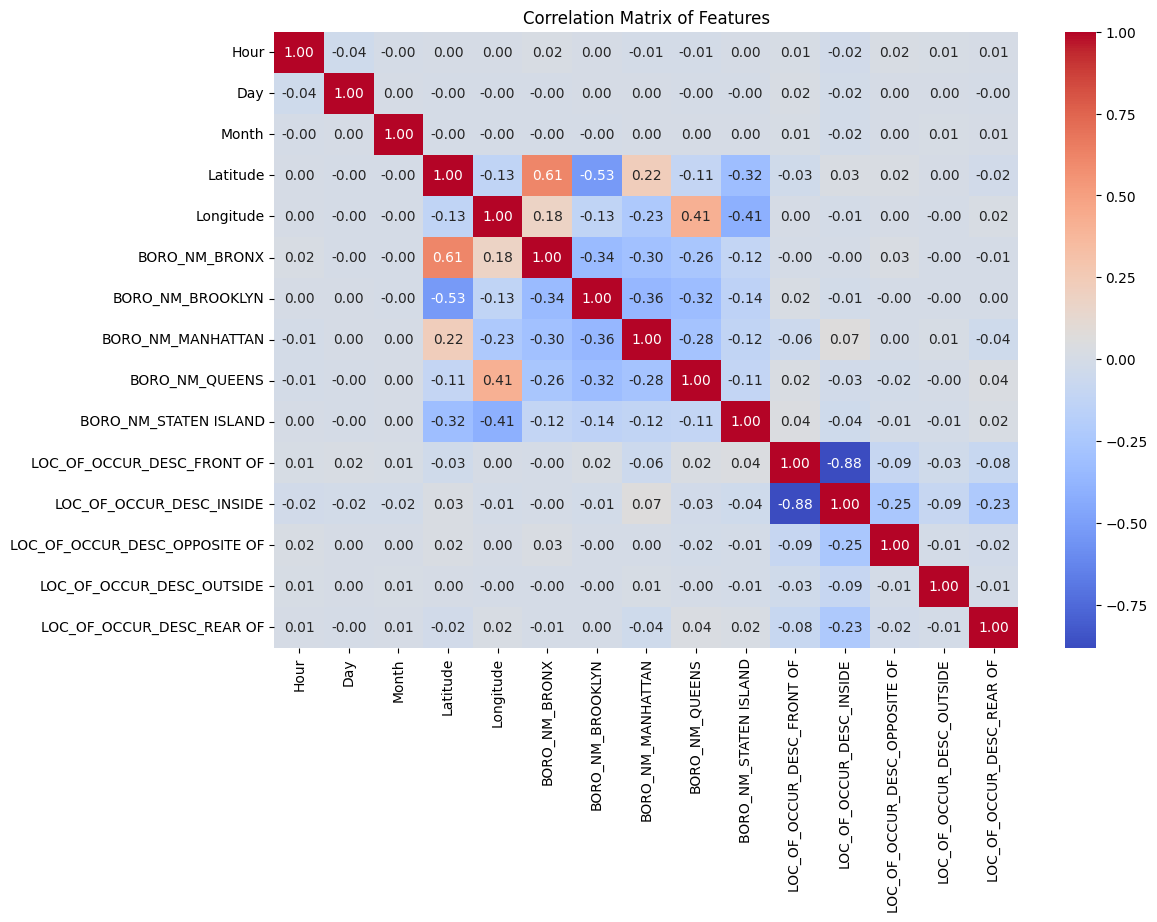

In [8]:
features = [feature for feature in features if 'OFNS_DESC' not in feature]
correlation_matrix = nypd_data_sample[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()